# SARA-mini

This tutorial introduces the basic classes and methods of the SARAwater package.

The figure below illustrates the workflow of the sarawater package, highlighting its components. In this tutorial, we will focus on the incoming flow time series ($Q_{nat}$), the flow requirement ($Q_{req}$), and the released flow time series ($Q_{rel}$). These three quantities contribute to the mass balance at the diversion, which reads

\begin{equation*}
Q_{nat} = Q_{abs} + Q_{rel}
\tag{1}
\end{equation*}

<img src="../images/SARA_overview.png" width="800">


## Importing external libraries

Let's start by importing the necessary external libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import ndarray

## Defining SARA classes

The classes defined below are a shrinked version of those implemented in the package. However, they are sufficient to get the basics off how SARA works!

### The `Scenario` class and its child classes

The parent class `Scenario` and its child classes `ConstScenario` and `PropScenario` are used to define different water management scenarios for a river reach. Each scenario specifies how much water is required to be released from the reach (i.e., the "flow requirement") based on different criteria.

In [2]:
class Scenario:
    def __init__(self, name: str, description: str, reach: "Reach", Qabs_max=None):  # type: ignore
        """Parent class for all types of scenarios. Contains the name and description of the scenario.

        Parameters
        ----------
        name : str
            Name of the scenario.
        description : str
            Description of the scenario.
        reach : Reach
            The reach object associated with this scenario.
        Qabs_max : float, optional
            Maximum value for the water abstraction, by default None (which takes the value from the reach object).
        """
        self.name = name
        self.description = description
        self.reach = reach
        self.Qreq = None  # Flow requirement time series
        self.Qrel = None  # Released flow rate time series
        if Qabs_max is None:  # Maximum abstraction
            self.Qabs_max = reach.Qabs_max
        else:
            self.Qabs_max = Qabs_max

    @property
    def Qnat(self) -> ndarray:
        """Get the natural flow rate time series from the associated Reach."""
        return self.reach.Qnat

    @property
    def dates(self) -> list:
        """Get the dates from the associated Reach."""
        return self.reach.dates

    def compute_Qrel(self) -> ndarray:
        """Compute the released flow rate time series for the scenario.

        Returns
        -------
        ndarray
            Released flow rate time series.
        """
        if self.Qreq is None:
            raise ValueError("Qreq must be set before computing Qrel.")

        Qrel = np.zeros_like(self.Qnat)
        case1 = self.Qnat <= self.Qreq
        case2 = (self.Qnat > self.Qreq) & (self.Qnat < self.Qabs_max + self.Qreq)
        case3 = self.Qnat >= self.Qabs_max + self.Qreq
        Qrel[case1] = self.Qnat[case1]
        Qrel[case2] = self.Qreq[case2]
        Qrel[case3] = self.Qnat[case3] - self.Qabs_max
        self.Qrel = Qrel
        return Qrel

`ConstScenario`: the child class for scenarios with fixed monthly flow requirements

In [3]:
class ConstScenario(Scenario):
    def __init__(
        self, name: str, description: str, reach: "Reach", Qreq_months: list[float], **kwargs  # type: ignore
    ):
        """Constant flow rate scenario.

        Parameters
        ----------
        name : str
            Name of the scenario.
        description : str
            Description of the scenario.
        reach : Reach
            The reach object associated with this scenario.
        Qreq_months : list[float]
            Monthly constant flow rates.
        """
        super().__init__(name, description, reach, **kwargs)

        if len(Qreq_months) != 12:
            raise ValueError("Qreq_months must have 12 elements.")
        self.Qreq_months = Qreq_months

        # Map the monthly flow rates to the dates of the reach
        self.Qreq = np.zeros_like(self.Qnat)
        for i, month in enumerate(self.Qreq_months):
            month_mask = np.array([date.month == i + 1 for date in self.dates])
            self.Qreq[month_mask] = month

`PropScenario`: the child class for scenarios with flow requirements proportional to the incoming flow. In scenarios with a proportional flow requirement, $Q_{req}$ is computed as a fraction of the incoming flow discharge, $Q_{in}$, according to the formula:

\begin{equation*}
Q_{req} = Q_{base} + c_{in} \cdot Q_{in} \tag{2},
\end{equation*}

where $Q_{base}$ is a base flow requirement (e.g., to maintain minimum ecological conditions), and $c_{in}$ is a coefficient that defines the proportion of the incoming flow to be included in the flow requirement.

This formula is then adjusted to ensure that $Q_{req}$ remains within user-specified minimum and maximum bounds, $Q_{req,min}$ and $Q_{req,max}$, respectively. This step is needed because low flow requirements may cause severe alteration in the downstream reach, while high flow requirements may lead to a very low water abstraction, which might not be sufficient. The complete definition of $Q_{req}$ in proportional scenarios is given by the piecewise function:

\begin{equation*}
Q_{req}=
\left\{
\begin{array}{lll}
Q_{req,min} & \text { if } & Q_{base} + c_{in} \cdot Q_{in} \leq Q_{req,min}\\[1ex]
 Q_{base} + c_{in} \cdot Q_{in} & \text { if } & Q_{req,min}<Q_{base} + c_{in} \cdot Q_{in}<Q_{req,max}\\[1ex]
Q_{req,max} & \text { if } & Q_{base} + c_{in} \cdot Q_{in}>Q_{req,max}. \\
\end{array}
\right.
\tag{3}
\end{equation*}

In [4]:
class PropScenario(Scenario):
    def __init__(
        self,
        name: str,
        description: str,
        reach: "Reach",  # type: ignore
        Qbase: float,
        c_in: float,
        Qreq_min: float,
        Qreq_max: float,
        **kwargs,
    ):
        """Proportional flow rate scenario.

        Parameters
        ----------
        name : str
            Name of the scenario.
        description : str
            Description of the scenario.
        reach : Reach
            The reach object associated with this scenario.
        Qbase : float
            Base flow rate.
        c_in : float
            Coefficient for inflow.
        Qreq_min : float
            Minimum value for the prescribed minimum released flow rate.
        Qreq_max : float
            Maximum value for the prescribed minimum released flow rate.
        """
        super().__init__(name, description, reach, **kwargs)
        self.Qbase = Qbase
        self.c_in = c_in
        self.Qreq_min = Qreq_min
        self.Qreq_max = Qreq_max
        self.Qreq = Qbase + c_in * self.Qnat
        self.Qreq[self.Qreq < Qreq_min] = Qreq_min
        self.Qreq[self.Qreq > Qreq_max] = Qreq_max

### The `Reach` class

In [5]:
class Reach:
    def __init__(self, name: str, dates: list, Qnat: ndarray, Qabs_max: float):
        """Represents a river reach.

        Parameters
        ----------
        name : str
            Name of the reach.
        dates : list[datetime]
            List of dates for the time series.
        Qnat : ndarray
            Natural flow rate time series.
        Qabs_max : float
            Maximum value for the water abstraction.
        """
        self.name = name
        self.dates = dates
        self.Qnat = Qnat
        self.Qabs_max = Qabs_max
        self.scenarios: list[Scenario] = []

    def __str__(
        self,
    ):  # This method defines what is returned when we print() a Reach object
        return f"{self.name} is a Reach object with a flow time series with {len(self.Qnat)} elements. The date range starts from {min(self.dates)} and has {len(self.dates)} elements. The maximum flow abstraction is Qabs_max={self.Qabs_max} m3/s. So far, {len(self.scenarios)} scenarios have been added."

    def add_scenario(self, scenario: Scenario):
        """Add a scenario to the reach.

        Parameters
        ----------
        scenario : Scenario
            The scenario to add.

        Returns
        -------
        Reach
            The current reach instance.
        """
        self.scenarios.append(scenario)
        return self

    def print_scenarios(self):
        """Print the list of scenarios added to the reach."""
        for i, scenario in enumerate(self.scenarios):
            print(f"scenarios[{i}]: {scenario.name} | {scenario.description}")
        return None

## Let's create a Reach!

First, let's specify the path to the input CSV file containing the flow discharge time series for the reach.

**NOTE**: the CSV file should have at least two columns: "Date" and "Q", where "Date" contains the timestamps and "Q" contains the flow discharge values in cubic meters per second (m³/s).

In [6]:
csv_filepath = "daily_discharge_30y.csv"  # The csv file must be in the same folder as this notebook

Then, let's extract the timestamps and discharge data from the CSV file. To create a `Reach` object, we need to convert the "Date" column to a list of datetime objects and the "Q" (flow discharge) column into a numpy array.

In [7]:
# Read CSV with automatic date parsing
input_df = pd.read_csv(csv_filepath, parse_dates=["Date"])

# Convert the "Date" column to a list of datetime objects
datetime_list = input_df["Date"].dt.to_pydatetime().tolist()

# Convert the "Q" (flow discharge) column into a numpy array
discharge_data = np.array(input_df["Q"].to_list())

C:\Users\gbarile\AppData\Local\Temp\ipykernel_29088\1103194211.py:5: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  datetime_list = input_df['Date'].dt.to_pydatetime().tolist()


### Initialize a reach object

The only ingredient left to create a `Reach` is the maximum flow discharge that can be abstracted from the reach.

In [8]:
Qabs_max = 3

Finally, let's create our `Reach` object!

In [9]:
my_reach = Reach("My Reach", datetime_list, discharge_data, Qabs_max)

## Adding scenarios to the reach object

#### Minimum Flow Requirement (MFR) scenario with fixed monthly requirements

In [10]:
Qreq_months = np.array(
    [0.1, 0.1, 0.1, 0.12, 0.12, 0.12, 0.12, 0.1, 0.1, 0.12, 0.12, 0.1]
)  # values are in m3/s, representing minimum release for each month

# Create a constant scenario with these values
const_scenario = ConstScenario(
    name="Constant Scenario",
    description="Minimum release scenario with constant monthly values",
    reach=my_reach,
    Qreq_months=Qreq_months,
)

# Add the scenario to the reach
my_reach.add_scenario(const_scenario)

#### Proportional release scenario

In [11]:
prop_scenario = PropScenario(
    name="Proportional Scenario",
    description="Proportional scenario with arbitrary parameters",
    reach=my_reach,
    Qbase=0.06,
    c_in=0.3,
    Qreq_min=np.min(Qreq_months),
    Qreq_max=1.3 * np.max(Qreq_months),
)
my_reach.add_scenario(prop_scenario)

#### Let's check we added the scenarios correctly

In [12]:
my_reach.print_scenarios()

scenarios[0]: Constant Scenario | Minimum release scenario with constant monthly values
scenarios[1]: Proportional Scenario | Proportional scenario with arbitrary parameters


## Compute the released flow discharge for each scenario

Given the incoming flow discharge $Q_{nat}$, the flow requirement $Q_{req}$ and the maximum abstractable flow $Q_{max}$, the released flow discharge $Q_{rel}$ is computed as:
\begin{equation*}
Q_{rel}=
\left\{
\begin{array}{lll}
Q_{nat} & \text { if } & Q_{nat} \leq Q_{req} & (4.1)\\[1ex]
Q_{req} & \text { if } & Q_{req}<Q_{nat}<Q_{req}+Q_{abs,max}& (4.2)\\[1ex]
Q_{nat}-Q_{abs,max} & \text { if } & Q_{nat} \geq Q_{req}+ Q_{abs,max} & (4.3)\\[1ex]
\end{array}
\right.
\end{equation*}

Where the three cases correspond to the following:
* $(4.1)$ The incoming flow $Q_{nat}$ is lower than the flow requirement $Q_{req}$; therefore, no water is abstracted and the released flow discharge $Q_{rel}$ equals the incoming flow. This usually happens in low-flow periods.
* $(4.2)$ There is enough incoming flow to satisfy the flow requirement, and the abstracted flow discharge $Q_{abs}$ is lower than the maximum abstractable flow $Q_{abs,max}$. Recall that, according to Equation $(1)$, $Q_{abs} = Q_{nat}-Q_{rel}$ (where, in this case, $Q_{rel}=Q_{req}$). This is the most "common" case, where the flow requirement rule is applied straightforwardly.
* $(4.3)$ The incoming flow $Q_{nat}$ is so large that the maximum abstractable flow can be diverted while still releasing a flow rate larger than the flow requirement. This usually happens during flood events.

The piecewise function $(4.1-4.3)$ is implemented in the `compute_Qrel` method of the class `Scenario`; therefore, to compute the released flow time series for each scenario we can simply write

In [13]:
for scenario in my_reach.scenarios:
    scenario.compute_Qrel()

## Plot the released flow discharge time series for each scenario

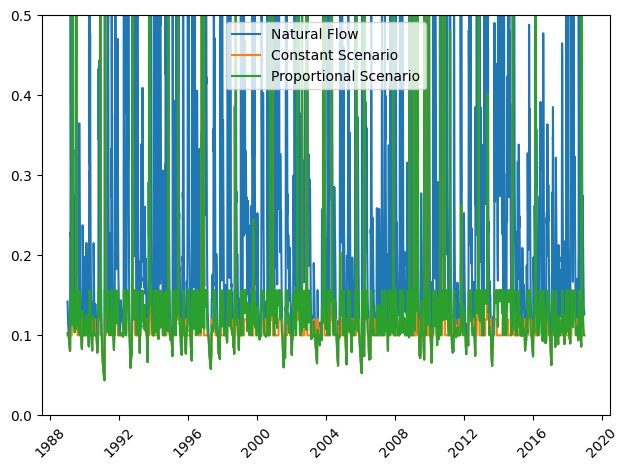

In [14]:
plt.plot(my_reach.dates, my_reach.Qnat, label="Natural Flow")
for scenario in my_reach.scenarios:
    plt.plot(scenario.dates, scenario.Qrel, label=scenario.name)
plt.xticks(rotation=45)
plt.legend()
plt.ylim(0, 0.5)
plt.tight_layout()

What a messy plot! Lets focus on one year only. First, let's create a Boolean array (a `mask`) to filter the dates within the year 2018.

In [15]:
start_date = pd.to_datetime("2018-01-01")
end_date = pd.to_datetime("2018-12-31")
mask = [(dt >= start_date) and (dt <= end_date) for dt in my_reach.dates]

Then, let's plot the released flow discharge for each scenario in the time interval we specified

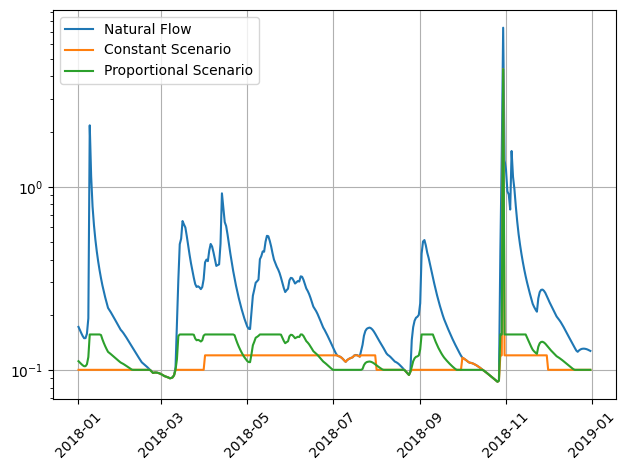

In [16]:
plt.plot(np.array(my_reach.dates)[mask], my_reach.Qnat[mask], label="Natural Flow")
for scenario in my_reach.scenarios:
    plt.plot(np.array(scenario.dates)[mask], scenario.Qrel[mask], label=scenario.name)
plt.xticks(rotation=45)
plt.legend()
plt.yscale("log")
plt.grid()
plt.tight_layout()